Note: This notebook contains very less documentation. To access full documentation please refer to main_project.ipynb

**USING AMES HOUSING DATASET**

In [ ]:
!pip install quantile_forest
import altair as alt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_random_state
from quantile_forest import RandomForestQuantileRegressor

data = pd.read_csv("ames.csv")

# data.dropna(inplace=True)
ordinal_cols = ordinal_cols = ["MS Zoning", "Street", "Alley", "Lot Shape", "Land Contour", "Utilities", "Lot Config", "Land Slope",
                "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl",
                "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Exter Qual", "Exter Cond", "Foundation", "Bsmt Qual",
                "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating", "Heating QC", "Central Air", "Electrical",
                "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Type", "Garage Finish", "Garage Qual",
                "Garage Cond", "Paved Drive", "Pool QC", "Fence", "Misc Feature", "Sale Type", "Sale Condition"]  # specify the categorical columns to encode
for col in ordinal_cols:
    data[col] = data[col].astype("category").cat.codes

data.dropna(inplace=True)
X = data.drop(["SalePrice"], axis=1).values
y = data["SalePrice"].values

qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# X[1]

data = {"y_true": [], "y_pred": [], "y_pred_low": [], "y_pred_upp": []}
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    qrf.set_params(max_features=X_train.shape[1] // 3)
    qrf.fit(X_train, y_train)

    # Get predictions at 95% prediction intervals and median.
    y_pred_i = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])

    data["y_true"].extend(y_test)
    data["y_pred"].extend(y_pred_i[:, 1])
    data["y_pred_low"].extend(y_pred_i[:, 0])
    data["y_pred_upp"].extend(y_pred_i[:, 2])

df = pd.DataFrame(data).pipe(lambda x: x * 1)  # convert to dollars


def plot_calibration_and_intervals(df):
    def plot_calibration(df):
        domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
        ]

        base = alt.Chart(df)

        circle = base.mark_circle(size=30).encode(
            x=alt.X(
                "y_pred:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Fitted Values (conditional median)",
            ),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Observed Values",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("y_pred:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("y_pred:Q", title=""), color=alt.value("#006aff")
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        diagonal = (
            alt.Chart(
                pd.DataFrame({"var1": [domain[0], domain[1]], "var2": [domain[0], domain[1]]})
            )
            .mark_line(color="black", opacity=0.4, strokeDash=[2, 2])
            .encode(
                x=alt.X("var1:Q"),
                y=alt.Y("var2:Q"),
            )
        )

        chart = bar + tick_low + tick_upp + circle + diagonal
        return chart

    def plot_intervals(df):
        df = df.copy()

        # Order samples by interval width.
        y_pred_interval = df["y_pred_upp"] - df["y_pred_low"]
        sort_idx = np.argsort(y_pred_interval)
        df = df.iloc[sort_idx]
        df["idx"] = np.arange(len(df))

        # Center data, with the mean of the prediction interval at 0.
        mean = (df["y_pred_low"] + df["y_pred_upp"]) / 2
        df["y_true"] -= mean
        df["y_pred"] -= mean
        df["y_pred_low"] -= mean
        df["y_pred_upp"] -= mean

        x_domain = [0, len(df)]
        y_domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("idx:Q", format=",d", title="Sample Index"),
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price (Centered)"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price (Centered)"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
            alt.Tooltip("y_pred_width:Q", format="$,d", title="Prediction Interval Width"),
        ]

        base = alt.Chart(df).transform_calculate(
            y_pred_width=alt.datum["y_pred_upp"] - alt.datum["y_pred_low"]
        )

        circle = base.mark_circle(size=30).encode(
            x=alt.X("idx:Q", axis=alt.Axis(format=",d"), title="Ordered Samples"),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                title="Observed Values and Prediction Intervals (centered)",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("idx:Q", scale=alt.Scale(domain=x_domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=y_domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("idx:Q", title=""),
            color=alt.value("#006aff"),
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        chart = bar + tick_low + tick_upp + circle
        return chart

    chart1 = plot_calibration(df).properties(height=250, width=325)
    chart2 = plot_intervals(df).properties(height=250, width=325)
    chart = chart1 | chart2

    return chart


chart = plot_calibration_and_intervals(df)
chart

alt.HConcatChart(...)

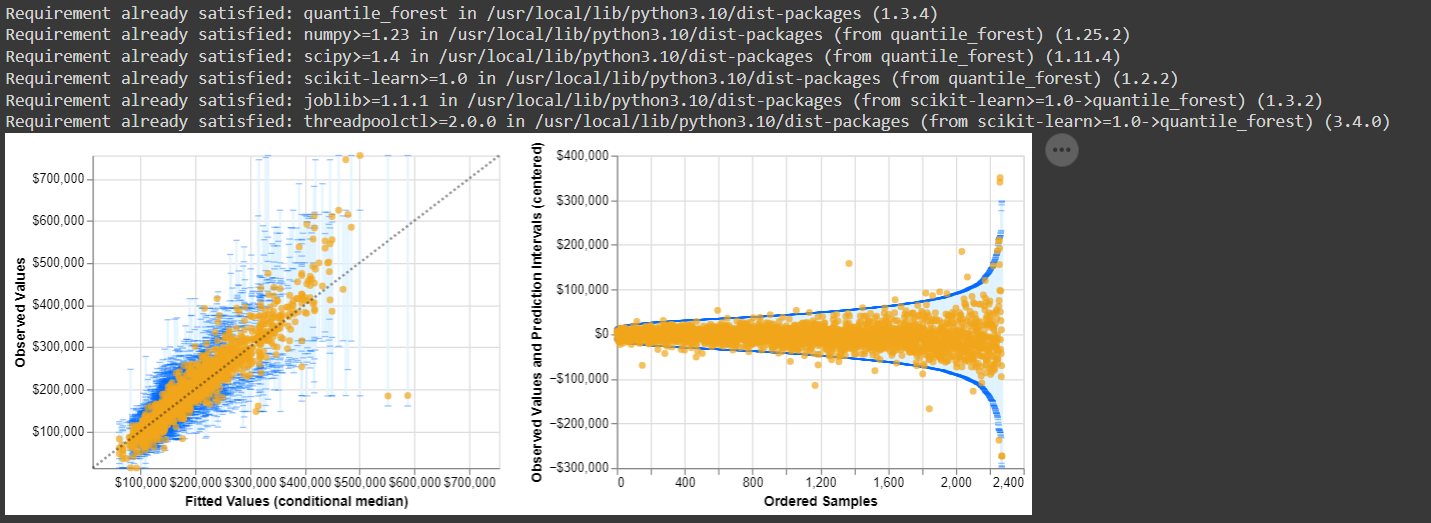

**PREDICTION OF CROWDEDNESS AT CAMPUS GYM**

In [ ]:
import numpy as np
import altair as alt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_random_state
from quantile_forest import RandomForestQuantileRegressor
from datetime import time

def time_to_seconds(time):
    return time.hour * 3600 + time.minute * 60 + time.second

data = pd.read_csv("gym_data.csv",nrows=2000)
data = data.drop("date", axis=1)
noon = time_to_seconds(time(12, 0, 0))
data.timestamp = data.timestamp.apply(lambda t: abs(noon - t))
columns = ["day_of_week", "month", "hour"]
data = pd.get_dummies(data, columns=columns)
data.head(10)

# data = pd.read_csv('Train.csv',nrows=2000)
data.dropna(inplace=True)
# features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
# target = 'Item_Outlet_Sales'

# # Extract features and target
# X = data[features].values
# y = data[target].values
data1 = data.values
X = data1[:, 1:]  # all rows, no label
y = data1[:, 0]

qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# Using k-fold cross-validation, get predictions for all samples.
data = {"y_true": [], "y_pred": [], "y_pred_low": [], "y_pred_upp": []}
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    qrf.set_params(max_features=X_train.shape[1] // 3)
    qrf.fit(X_train, y_train)

    # Get predictions at 95% prediction intervals and median.
    y_pred_i = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])

    data["y_true"].extend(y_test)
    data["y_pred"].extend(y_pred_i[:, 1])
    data["y_pred_low"].extend(y_pred_i[:, 0])
    data["y_pred_upp"].extend(y_pred_i[:, 2])

df = pd.DataFrame(data).pipe(lambda x: x *1)  # convert to dollars


def plot_calibration_and_intervals(df):
    def plot_calibration(df):
        domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
        ]

        base = alt.Chart(df)

        circle = base.mark_circle(size=30).encode(
            x=alt.X(
                "y_pred:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Fitted Values (conditional median)",
            ),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Observed Values",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("y_pred:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("y_pred:Q", title=""), color=alt.value("#006aff")
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        diagonal = (
            alt.Chart(
                pd.DataFrame({"var1": [domain[0], domain[1]], "var2": [domain[0], domain[1]]})
            )
            .mark_line(color="black", opacity=0.4, strokeDash=[2, 2])
            .encode(
                x=alt.X("var1:Q"),
                y=alt.Y("var2:Q"),
            )
        )

        chart = bar + tick_low + tick_upp + circle + diagonal
        return chart

    def plot_intervals(df):
        df = df.copy()

        # Order samples by interval width.
        y_pred_interval = df["y_pred_upp"] - df["y_pred_low"]
        sort_idx = np.argsort(y_pred_interval)
        df = df.iloc[sort_idx]
        df["idx"] = np.arange(len(df))

        # Center data, with the mean of the prediction interval at 0.
        mean = (df["y_pred_low"] + df["y_pred_upp"]) / 2
        df["y_true"] -= mean
        df["y_pred"] -= mean
        df["y_pred_low"] -= mean
        df["y_pred_upp"] -= mean

        x_domain = [0, len(df)]
        y_domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("idx:Q", format=",d", title="Sample Index"),
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price (Centered)"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price (Centered)"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
            alt.Tooltip("y_pred_width:Q", format="$,d", title="Prediction Interval Width"),
        ]

        base = alt.Chart(df).transform_calculate(
            y_pred_width=alt.datum["y_pred_upp"] - alt.datum["y_pred_low"]
        )

        circle = base.mark_circle(size=30).encode(
            x=alt.X("idx:Q", axis=alt.Axis(format=",d"), title="Ordered Samples"),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                title="Observed Values and Prediction Intervals (centered)",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("idx:Q", scale=alt.Scale(domain=x_domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=y_domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("idx:Q", title=""),
            color=alt.value("#006aff"),
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        chart = bar + tick_low + tick_upp + circle
        return chart

    chart1 = plot_calibration(df).properties(height=250, width=325)
    chart2 = plot_intervals(df).properties(height=250, width=325)
    chart = chart1 | chart2

    return chart


chart = plot_calibration_and_intervals(df)
chart

alt.HConcatChart(...)

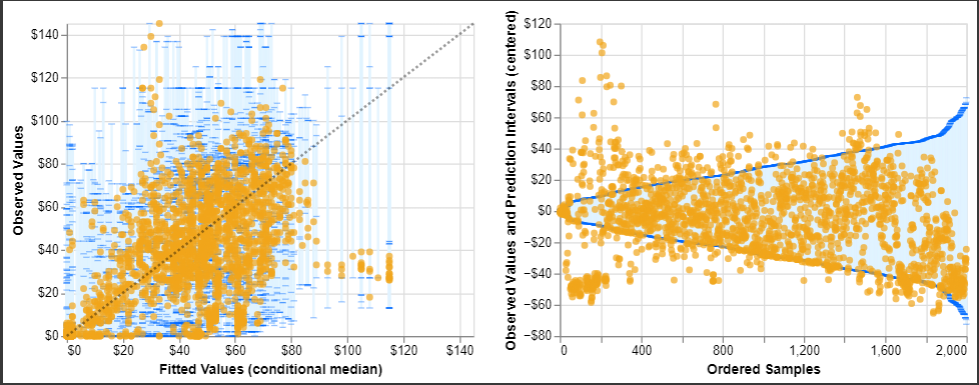

**USING BIGMART SALES DATSAET**

In [ ]:
import numpy as np
import altair as alt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_random_state
from quantile_forest import RandomForestQuantileRegressor
from datetime import time

data = pd.read_csv('bigmart_sales.csv',nrows=2000)
data.dropna(inplace=True)
features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
target = 'Item_Outlet_Sales'

# Extract features and target
X = data[features].values
y = data[target].values


qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

# Using k-fold cross-validation, get predictions for all samples.
data = {"y_true": [], "y_pred": [], "y_pred_low": [], "y_pred_upp": []}
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    qrf.set_params(max_features=X_train.shape[1] // 3)
    qrf.fit(X_train, y_train)

    # Get predictions at 95% prediction intervals and median.
    y_pred_i = qrf.predict(X_test, quantiles=[0.025, 0.5, 0.975])

    data["y_true"].extend(y_test)
    data["y_pred"].extend(y_pred_i[:, 1])
    data["y_pred_low"].extend(y_pred_i[:, 0])
    data["y_pred_upp"].extend(y_pred_i[:, 2])

df = pd.DataFrame(data).pipe(lambda x: x *1)  # convert to dollars


def plot_calibration_and_intervals(df):
    def plot_calibration(df):
        domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
        ]

        base = alt.Chart(df)

        circle = base.mark_circle(size=30).encode(
            x=alt.X(
                "y_pred:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Fitted Values (conditional median)",
            ),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                scale=alt.Scale(domain=domain, nice=False),
                title="Observed Values",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("y_pred:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("y_pred:Q", title=""), color=alt.value("#006aff")
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        diagonal = (
            alt.Chart(
                pd.DataFrame({"var1": [domain[0], domain[1]], "var2": [domain[0], domain[1]]})
            )
            .mark_line(color="black", opacity=0.4, strokeDash=[2, 2])
            .encode(
                x=alt.X("var1:Q"),
                y=alt.Y("var2:Q"),
            )
        )

        chart = bar + tick_low + tick_upp + circle + diagonal
        return chart

    def plot_intervals(df):
        df = df.copy()

        # Order samples by interval width.
        y_pred_interval = df["y_pred_upp"] - df["y_pred_low"]
        sort_idx = np.argsort(y_pred_interval)
        df = df.iloc[sort_idx]
        df["idx"] = np.arange(len(df))

        # Center data, with the mean of the prediction interval at 0.
        mean = (df["y_pred_low"] + df["y_pred_upp"]) / 2
        df["y_true"] -= mean
        df["y_pred"] -= mean
        df["y_pred_low"] -= mean
        df["y_pred_upp"] -= mean

        x_domain = [0, len(df)]
        y_domain = [
            int(np.min(np.minimum(df["y_true"], df["y_pred"]))),  # min of both axes
            int(np.max(np.maximum(df["y_true"], df["y_pred"]))),  # max of both axes
        ]

        tooltip = [
            alt.Tooltip("idx:Q", format=",d", title="Sample Index"),
            alt.Tooltip("y_true:Q", format="$,d", title="Actual Price (Centered)"),
            alt.Tooltip("y_pred:Q", format="$,d", title="Predicted Price (Centered)"),
            alt.Tooltip("y_pred_low:Q", format="$,d", title="Predicted Lower Price"),
            alt.Tooltip("y_pred_upp:Q", format="$,d", title="Predicted Upper Price"),
            alt.Tooltip("y_pred_width:Q", format="$,d", title="Prediction Interval Width"),
        ]

        base = alt.Chart(df).transform_calculate(
            y_pred_width=alt.datum["y_pred_upp"] - alt.datum["y_pred_low"]
        )

        circle = base.mark_circle(size=30).encode(
            x=alt.X("idx:Q", axis=alt.Axis(format=",d"), title="Ordered Samples"),
            y=alt.Y(
                "y_true:Q",
                axis=alt.Axis(format="$,d"),
                title="Observed Values and Prediction Intervals (centered)",
            ),
            color=alt.value("#f2a619"),
            tooltip=tooltip,
        )

        bar = base.mark_bar(opacity=0.8, width=2).encode(
            x=alt.X("idx:Q", scale=alt.Scale(domain=x_domain, padding=0), title=""),
            y=alt.Y("y_pred_low:Q", scale=alt.Scale(domain=y_domain, padding=0), title=""),
            y2=alt.Y2("y_pred_upp:Q", title=None),
            color=alt.value("#e0f2ff"),
            tooltip=tooltip,
        )

        tick = base.mark_tick(opacity=0.4, orient="horizontal", thickness=1, width=5).encode(
            x=alt.X("idx:Q", title=""),
            color=alt.value("#006aff"),
        )
        tick_low = tick.encode(y=alt.Y("y_pred_low:Q", title=""))
        tick_upp = tick.encode(y=alt.Y("y_pred_upp:Q", title=""))

        chart = bar + tick_low + tick_upp + circle
        return chart

    chart1 = plot_calibration(df).properties(height=250, width=325)
    chart2 = plot_intervals(df).properties(height=250, width=325)
    chart = chart1 | chart2

    return chart


chart = plot_calibration_and_intervals(df)
chart

alt.HConcatChart(...)

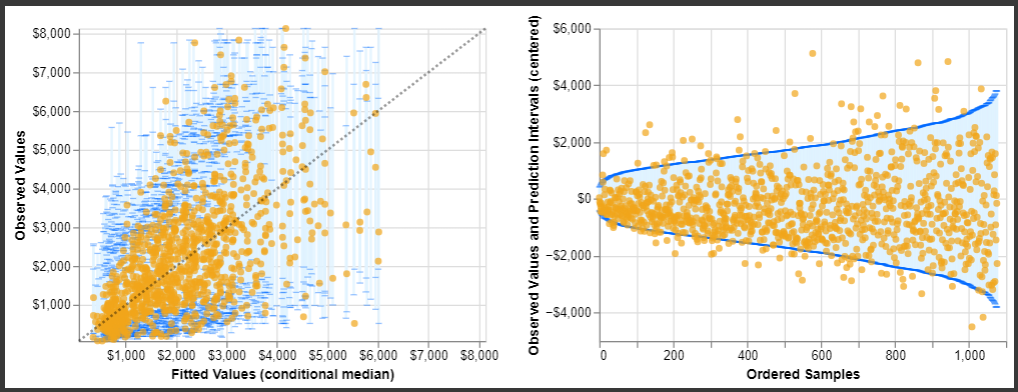